# Mechanical benchmark
### A linear elasticity model is solved with $p$-th order Lagrange finite elements

Load modules for FEniCS and PyVista

In [2]:
from __future__ import print_function
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('panel')  
pv.start_xvfb()

Read the mesh file from specified path

In [3]:
mesh = Mesh("../../benchmarks/data_files/mesh_data/hearth.xml")
domains = MeshFunction('size_t',mesh,mesh.topology().dim()) # Read domain marker
subdomains = MeshFunction("size_t", mesh, "../../benchmarks/data_files/mesh_data/hearth_physical_region.xml") # Read subdomain markers
boundaries = MeshFunction("size_t", mesh, "../../benchmarks/data_files/mesh_data/hearth_facet_region.xml") # Read boundary markers
dx = Measure('dx', domain = mesh, subdomain_data = domains) # Volume measure
ds = Measure('ds', domain = mesh, subdomain_data = boundaries) # Boundary measure
n = as_vector(FacetNormal(mesh)) # Edge unit normal vector

Markers for different parts of the boundary

In [4]:
d_bottom = ds(2) + ds(3) + ds(4) + ds(5) + ds(6) # Markers of bottom boundary \gamma_{-}
d_out = ds(7) + ds(8) + ds(9) + ds(10) + ds(11) # Markers of outer boundary \gamma_{out}
d_sf = ds(13) + ds(14) + ds(15) + ds(16) + ds(17) + ds(18) + ds(19) + ds(20) # Markers of inner boundary \gamma_{sf}

Computation of $\mathbf{U}$ norm

In [5]:
def compute_U_norm(phi,mesh):
    x = SpatialCoordinate(mesh)
    dx = Measure('dx', domain = mesh)
    a = inner(phi,phi)*x[0]*dx + inner(grad(phi),grad(phi))*x[0]*dx + (phi[0]**2)/x[0]*dx
    A = assemble(a)
    return sqrt(A)

Axisymmetric strain tensor definition. Alternative could be to express strain as vector using Voigt notation.

In [6]:
def eps(u): 
    return \
        sym(as_tensor([[u[0].dx(0), u[0].dx(1), 0. ],\
        [u[1].dx(0), u[1].dx(1), 0.],\
        [0., 0., u[0]/x[0]]]))

Axisymmetric stress tensor definition. Alternative could be to express stress as vector using Voigt notation.

In [7]:
def sigma(u):
    return lmbda * tr(eps(u)) * Identity(3) + 2.0 * mu * eps(u)

Physical model constant and exact solution

In [8]:
# Known analytical solution, Mechanical material properties and Boundary data
u_analytical = Expression(("A * x[0] * x[1] * x[1]","A * x[0] * x[0] * x[1]"),A=1e-4,degree=3) 
# analytical solution started as expression and projected onto relevant funtion space
VM_analytical = VectorFunctionSpace(mesh,"CG",3)
u_analytical = project(u_analytical,VM_analytical)
E = Constant(5e9) # Young's modulus
nu = Constant(0.2) # Poisson's ratio
mu = E/2/(1+nu) # Lam\'e parameter
lmbda = E*nu/(1+nu)/(1-2*nu) # Lam\'e parameter

Compute the Finite Element approximation for different discretizations using $p$-th order Lagrange elements

In [9]:
error_u_vector = [] #List for absolute error in displacement
p = range(1,4) #Polynomial degrees
for i in p:
    # Define function space
    VM = VectorFunctionSpace(mesh,"CG",i) # Function space for displacement
    x = Expression(("x[0]","x[1]"), element=VM.ufl_element())
    VS = FunctionSpace(mesh,"CG",max(i-1,1)) 
    # Function space for Von Mises stress NOTE: when i=1, the VS is of degree 1 and not 0.
    phi, u_ = TestFunction(VM), TrialFunction(VM)
    u = Function(VM, name = "Displacement") # u[0] = u_r and u[1] = u_y
    
    # Dirichlet boundary data
    bcs_M = [DirichletBC( VM.sub(0), Constant(0.), 'x[0] < DOLFIN_EPS and on_boundary'), \
    DirichletBC( VM.sub(1), Constant(0.), 'near(x[1],0) and on_boundary')] 
    # Set Dirichlet boundary. Note that only functions which satisfy zero normal displacement on \gamma_s \cup \gamma_- are admissible.
    
    # Source term and relevant boundary data
    f0_r = - (2*E*nu*1e-4*x[0]/(1-2*nu)/(1+nu)+2*E*1e-4*x[0]/(1+nu)) 
    f0_y = - (4*E*1e-4*x[1]/(1+nu)+4*E*1e-4*x[1]*nu/(1-2*nu)/(1+nu)) 
    
    g_plus_r = 2*E*1e-4*x[0]*x[1]/(1+nu)
    g_plus_y = E / (1-2*nu) / (1+nu) * (2*nu*1e-4*x[1]*x[1]+(1-nu)*1e-4*x[0]*x[0])

    g_minus_r = -g_plus_r

    g_sf_r = E / (1-2*nu) / (1+nu) * (1e-4 * x[1] * x[1] + nu * 1e-4 * x[0] * x[0]) * n[0] + 2 * E * 1e-4 * x[0] * x[1] / (1 + nu) * n[1]
    g_sf_y = 2 * E * 1e-4 * x[0] * x[1] / (1 + nu) * n[0] + E / (1-2*nu) / (1+nu) * (2 * nu * 1e-4 * x[1] * x[1] + (1 - nu) * 1e-4 * x[0] * x[0]) * n[1]

    g_out_r = E / (1-2*nu) / (1+nu) * (1e-4 * x[1] * x[1] + nu * 1e-4 * x[0] * x[0])
    g_out_y = 2*E*1e-4*x[0]*x[1]/(1+nu)
    
    # solving weak form of momentum equation
    # Bilinear form
    a_M = inner(sigma(u_),eps(phi)) * x[0] * dx
    #linear form
    l_M = (phi[0] * f0_r + phi[1] * f0_y) * x[0] * dx + (phi[0] * g_plus_r + phi[1] * g_plus_y) * x[0] * ds(12) + \
    (phi[0] * g_minus_r) * x[0] * d_bottom + (phi[0] * g_sf_r + phi[1] * g_sf_y) * x[0] * d_sf + \
    (phi[0] * g_out_r + phi[1] * g_out_y) * x[0] * d_out
    solve(a_M == l_M, u, bcs_M)

    # Von Mises stress computed displacement
    sigma_dev = sigma(u) - tr(sigma(u)) / 3 * Identity(3) 
    sigma_vm = sqrt(3 * inner( sigma_dev, sigma_dev) / 2) # Von mises stress
    # Von Mises stress analytical displacement
    sigma_dev_analytical = sigma(u_analytical) - tr(sigma(u_analytical)) / 3 * Identity(3)
    sigma_vm_analytical = sqrt(3 * inner( sigma_dev_analytical, sigma_dev_analytical) / 2) # Von mises stress

    # Compute H^1_r norm of error
    error_u = compute_U_norm(u_analytical-u,mesh)/compute_U_norm(u_analytical,mesh)
    error_u_vector.append(error_u)
    print("Relative error in U-norm : ",str(error_u))

Solving linear variational problem.
Relative error in U-norm :  0.006730178170963908
Solving linear variational problem.
Relative error in U-norm :  2.9804181751541996e-05
Solving linear variational problem.
Relative error in U-norm :  1.2982935160501894e-13


Post-processing and visualization for the displacement field and its error

In [10]:
# Post-processing and visualization
u.rename("Displacement","u")
u_analytical.rename("Displacement","u")
File("../../benchmarks/result_files/mechanical_model/displacement_computed.pvd") << u
File("../../benchmarks/result_files/mechanical_model/displacement_analytical.pvd") << u_analytical
File("../../benchmarks/result_files/mechanical_model/displacement_error.pvd") << project(u_analytical-u,VM)

In [11]:
mesh = pv.read("../../benchmarks/result_files/mechanical_model/displacement_computed000000.vtu")
pl = pv.Plotter(window_size=[600, 600])
pl.add_mesh(mesh,scalars="Displacement", show_edges=True)
pl.view_xy();pl.show_axes()
pl.show()

Post-processing and visualization for the Von Mises stress and its error

In [12]:
sigma_vm_proj = project(sigma_vm,VS)
sigma_vm_proj.rename("Von Misses","sigma")
error_stress = Function(VS) #Function for absolute error in stress tensor
error_stress.vector()[:] = abs(project(sigma_vm,VS).vector().get_local() - project(sigma_vm_analytical,VS).vector().get_local())
File("../../benchmarks/result_files/mechanical_model/von_mises_stress_computed.pvd") << sigma_vm_proj
File("../../benchmarks/result_files/mechanical_model/von_mises_stress_analytical.pvd") << project(sigma_vm_analytical,VS)
File("../../benchmarks/result_files/mechanical_model/von_mises_stress_error.pvd") << project(error_stress,VS)

In [13]:
mesh = pv.read("../../benchmarks/result_files/mechanical_model/von_mises_stress_computed000000.vtu")
pl = pv.Plotter(window_size=[600, 600])
pl.add_mesh(mesh,scalars="Von Misses", show_edges=True)
pl.view_xy();pl.show_axes()
pl.show()

Convergence tests

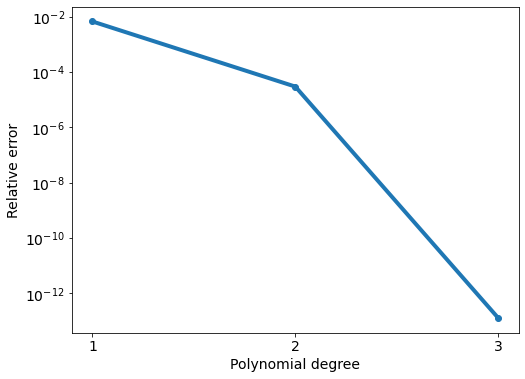

Relative error in U norm: [0.006730178170963908, 2.9804181751541996e-05, 1.2982935160501894e-13]


In [14]:
plt.figure(figsize=[8,6])
a = plt.semilogy([1,2,3],error_u_vector,marker='o',linewidth=4)
plt.xticks([1,2,3],fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Polynomial degree',fontsize=14)
plt.ylabel('Relative error',fontsize=14)
plt.axis('tight')
plt.savefig("../../benchmarks/result_files/mechanical_model/convergence_test")
plt.show() # To show the plots

print("Relative error in U norm: "+ str(error_u_vector))